<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/ColabNotebooks/FasterRCNN/Alexnet_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

/content/drive/MyDrive/Colab Notebooks/20220819
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from pycocotools.coco import COCO
import utils

from WoodDataset import FasterRCNN_WoodDataset

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

A100-SXM4-40GB


In [4]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [6]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [7]:
train_data = FasterRCNN_WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = FasterRCNN_WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = FasterRCNN_WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [8]:
batch_size = 32
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from Models import FasterRCNN_Backbone_Alexnet

modelname = 'Alexnet'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FasterRCNN_Backbone_Alexnet(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


In [ ]:
# model.load_state_dict(torch.load(os.path.join('models', 'Alexnet_SGD_epoch_102.pth')))

<All keys matched successfully>

In [10]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [11]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('FasterRCNN_logs_v2', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [12]:
def train_batch(model, images, targets):
  images = list(image.to(device) for image in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  loss_dict = model(images, targets)
  return loss_dict

In [16]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_valid_loss = np.array([1000., 1000., 1000., 1000.])
last_update_epoch = 0
for epoch in range(0, num_epochs):

    train_box_loss = []
    train_cls_loss = []
    train_obj_loss = []
    train_rpn_loss = []
    valid_box_loss = []
    valid_cls_loss = []
    valid_obj_loss = []
    valid_rpn_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:
        torch.cuda.empty_cache()
        batch_size = len(images)
        n += 1

        loss_dict = train_batch(model, images, targets)
        '''
        loss__dict = {'loss_classifier': ###, 
                      'loss_box_reg': ###, 
                      'loss_objectness': ###, 
                      'loss_rpn_box_reg': ###}
        '''        
        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()

        train_box_loss.append(box_loss)
        train_cls_loss.append(cls_loss)
        train_obj_loss.append(obj_loss)
        train_rpn_loss.append(rpn_loss)

        losses = sum(loss_dict.values())     # Returns losses and detections

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        now = time.time()

        if n % 30 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] box_loss: {box_loss:.4f}  cls_loss: {cls_loss:.4f}  obj_loss: {obj_loss:.4f}  rpn_loss: {rpn_loss:.4f}')
          print(f'Training time: {tstr}')      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    images = None
    targets = None  
    loss_dict = None  
    torch.cuda.empty_cache()
############################# valid #########################################           
    for images, targets in valid_data_loader:

        torch.cuda.empty_cache()
        loss_dict = train_batch(model, images, targets)

        cls_loss = loss_dict['loss_classifier'].item()
        box_loss = loss_dict['loss_box_reg'].item()
        obj_loss = loss_dict['loss_objectness'].item()
        rpn_loss = loss_dict['loss_rpn_box_reg'].item()
        losses = sum(loss_dict.values())

        valid_box_loss.append(box_loss)
        valid_cls_loss.append(cls_loss)
        valid_obj_loss.append(obj_loss)
        valid_rpn_loss.append(rpn_loss)
        # val_loss_hist.send(val_loss_value)
    images = None
    targets = None 
    loss_dict = None
    torch.cuda.empty_cache()

############################ log ###########################################
    epoch_train_box_loss = np.mean(train_box_loss)
    epoch_train_cls_loss = np.mean(train_cls_loss)
    epoch_train_obj_loss = np.mean(train_obj_loss)
    epoch_train_rpn_loss = np.mean(train_rpn_loss)
    epoch_valid_box_loss = np.mean(valid_box_loss)
    epoch_valid_cls_loss = np.mean(valid_cls_loss)
    epoch_valid_obj_loss = np.mean(valid_obj_loss)
    epoch_valid_rpn_loss = np.mean(valid_rpn_loss)

    current_valid_loss = np.array([epoch_valid_box_loss, 
                              epoch_valid_cls_loss, 
                              epoch_valid_obj_loss, 
                              epoch_valid_rpn_loss])

    now = time.time()
    writer.add_scalar('train/box_loss', epoch_train_box_loss, epoch, now)
    writer.add_scalar('train/cls_loss', epoch_train_cls_loss, epoch, now)
    writer.add_scalar('train/obj_loss', epoch_train_obj_loss, epoch, now)
    writer.add_scalar('train/rpn_loss', epoch_train_rpn_loss, epoch, now)
    writer.add_scalar('valid/box_loss', epoch_valid_box_loss, epoch, now)
    writer.add_scalar('valid/cls_loss', epoch_valid_cls_loss, epoch, now)
    writer.add_scalar('valid/obj_loss', epoch_valid_obj_loss, epoch, now)
    writer.add_scalar('valid/rpn_loss', epoch_valid_rpn_loss, epoch, now)

############################ save ##########################################   
    if sum(current_valid_loss < best_valid_loss) >= 3:
        best_valid_loss = current_valid_loss
        print(f'Model Updated! Validation box_loss: {best_valid_loss[0]:.4f}  cls_loss: {best_valid_loss[1]:.4f}  obj_loss: {best_valid_loss[2]:.4f}  rpn_loss: {best_valid_loss[3]:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch
#############################################################################
writer.close()

Epoch: [0] [30/90] box_loss: 0.0174  cls_loss: 0.1076  obj_loss: 0.1340  rpn_loss: 0.0329
Training time: 00:04:39
Epoch: [0] [60/90] box_loss: 0.0179  cls_loss: 0.1042  obj_loss: 0.1338  rpn_loss: 0.0378
Training time: 00:10:56
Epoch: [0] [90/90] box_loss: 0.0143  cls_loss: 0.0751  obj_loss: 0.1155  rpn_loss: 0.0264
Training time: 00:17:13
Model Updated! Validation box_loss: 0.0143  cls_loss: 0.0958  obj_loss: 0.1193  rpn_loss: 0.0278
Epoch: [1] [30/90] box_loss: 0.0143  cls_loss: 0.0701  obj_loss: 0.1109  rpn_loss: 0.0212
Training time: 00:20:40
Epoch: [1] [60/90] box_loss: 0.0077  cls_loss: 0.0702  obj_loss: 0.1087  rpn_loss: 0.0219
Training time: 00:21:41
Epoch: [1] [90/90] box_loss: 0.0185  cls_loss: 0.0677  obj_loss: 0.1102  rpn_loss: 0.0231
Training time: 00:22:43
Model Updated! Validation box_loss: 0.0135  cls_loss: 0.0802  obj_loss: 0.1153  rpn_loss: 0.0220
Epoch: [2] [30/90] box_loss: 0.0233  cls_loss: 0.0782  obj_loss: 0.1503  rpn_loss: 0.0344
Training time: 00:24:08
Epoch: [

KeyboardInterrupt: ignored

In [17]:
loss_dict

{'loss_classifier': tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0483, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0295, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>)}

In [18]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [29]:
idx = 0
model.load_state_dict(torch.load(os.path.join('models','Alexnet_SGD_epoch_102.pth')))
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

{'boxes': tensor([[ 90.1190, 334.3180, 114.8784, 402.9720],
         [ 71.7392, 343.4079, 111.5853, 379.7340],
         [  2.3535, 506.4206,  49.7034, 511.9947],
         [  2.3528, 506.4469,  49.6815, 511.9907],
         [  2.1692, 506.4678,  49.6264, 512.0000],
         [  2.2961, 506.4309,  49.7581, 512.0000],
         [  2.2066, 506.4595,  49.6547, 512.0000],
         [  2.2916, 506.4624,  49.4415, 511.9897],
         [  2.2945, 506.4227,  49.7732, 511.9989],
         [ 92.2382, 358.9024, 130.7472, 391.4092],
         [  2.0906, 506.4714,  49.6998, 511.9948],
         [ 72.3670, 342.9011, 110.9688, 380.1814],
         [867.9947, 264.7888, 896.0127, 291.0323],
         [868.6771, 242.9428, 889.1586, 328.0042],
         [855.0021, 257.3163, 912.6945, 293.1256],
         [ 67.3021, 329.8175,  95.0555, 393.3761],
         [ 68.2976, 324.8066,  93.8874, 390.1070],
         [877.7530, 271.7028, 897.2967, 305.3559],
         [101.5415, 361.1250, 144.1568, 396.9700],
         [867.6341, 26

In [30]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [31]:
bbox_pred

tensor([[ 90.1190, 334.3180, 114.8784, 402.9720],
        [  2.3535, 506.4206,  49.7034, 511.9947],
        [867.9947, 264.7888, 896.0127, 291.0323]], grad_fn=<ToCopyBackward0>)

In [32]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 2, 2])

Text(0.5, 1.0, 'Gt')

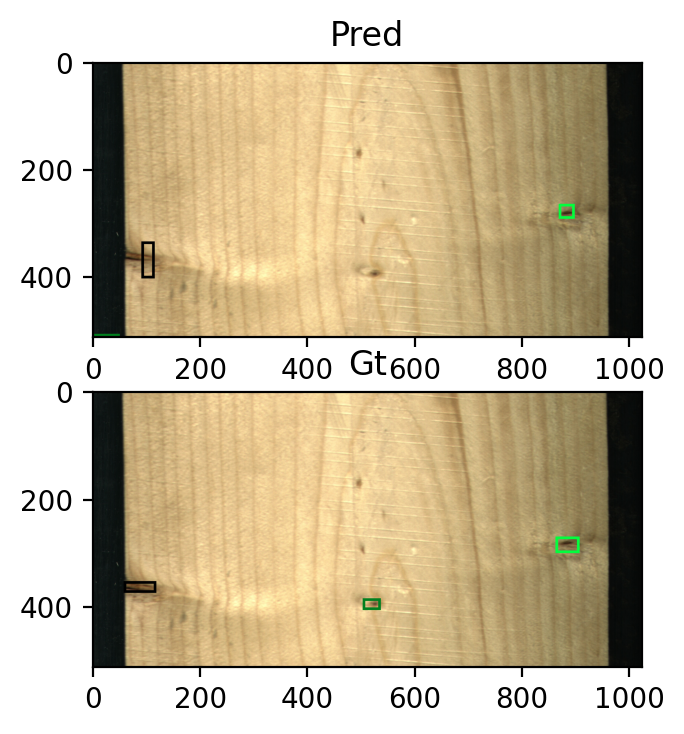

In [33]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [34]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.5).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(0.)

In [35]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [36]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

In [38]:
with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN.npy'), 'wb') as f:
  np.save(f, cls_cm)

In [37]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
print(f'class precision: {cls_precision.mean():.4f}, class recall: {cls_recall.mean():.4f}')

class precision: 0.1798, class recall: 0.2002


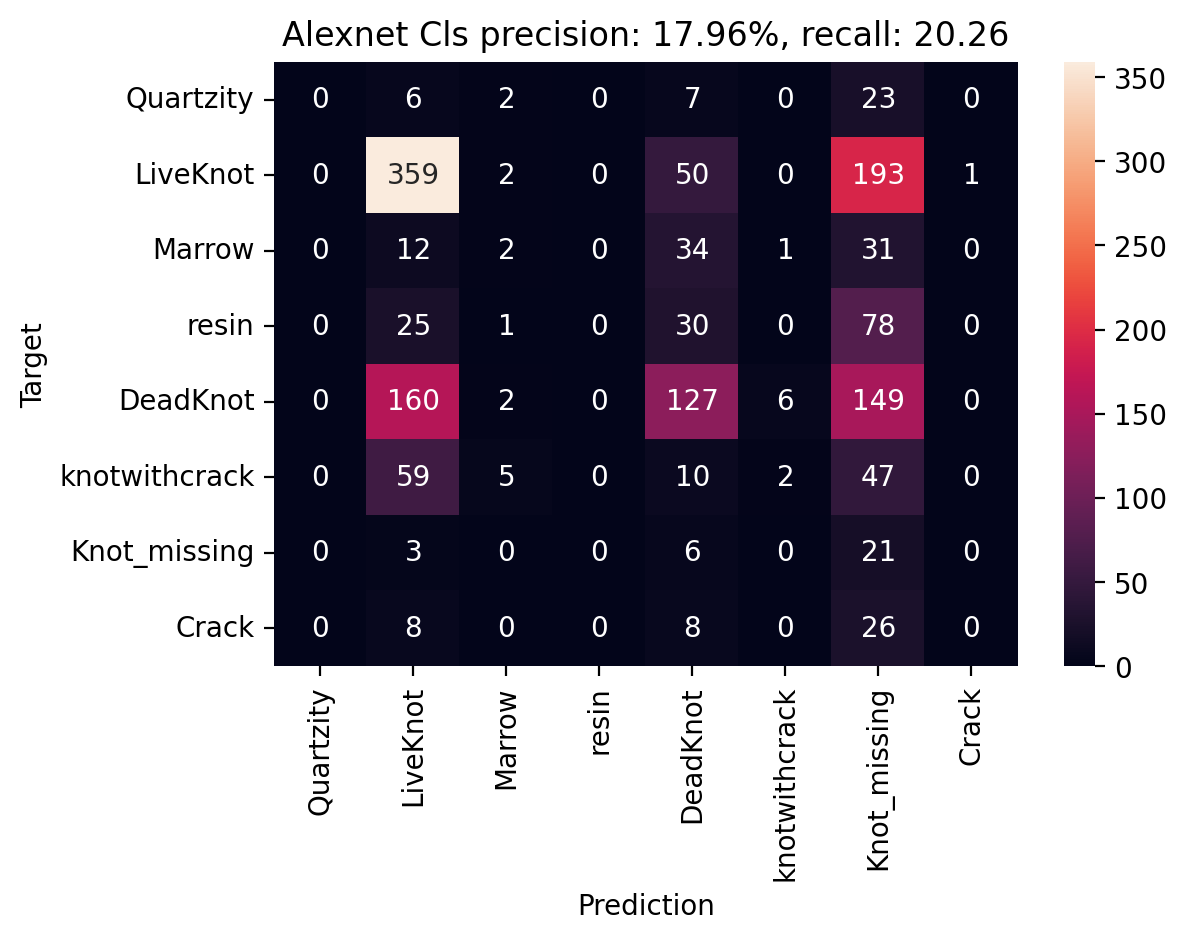

In [ ]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN.png'))
           

In [39]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

,box_precision,box_recall
0,0.000000,0.0
1,0.333333,0.5
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
5,0.500000,0.5
6,0.333333,0.5
7,0.000000,0.0
8,0.000000,0.0
9,0.000000,0.0


In [40]:
print(df['box_precision'].mean())
print(df['box_recall'].mean())

0.16825273868284726
0.26625101008243507


In [42]:
df.to_csv(os.path.join('Validation_csv', save_name.replace('pth', 'csv')))